### Diffusion equation:
$$\rho n \beta \frac{\partial p}{\partial t} + \frac{\partial}{\partial x}\left(-\frac{\rho k}{\eta} \frac{\partial p}{\partial x}\right) = 0$$

if density ($\rho$) is constant:
$$ \frac{\partial p}{\partial t} = \frac{1}{n \beta}\frac{\partial}{\partial x}\left(\frac{k}{\eta} \frac{\partial p}{\partial x}\right)$$

where,

$n$ : porosity

$\beta$ : compressibility

$k$ : permeability

$\eta$ : viscosity (Pa$\cdot$s)

### Parameters:

$n=0.1$

$\beta = \beta_0 = 1$

$k = k_0, k_0 = 1 \text{ md} = 10^{-3} \times 9.869233\times 10^{−13} \text{ m}^2$

Nolinear: $k = k_0  \exp\left(-\frac{p}{p_1}\right)$

$\eta = 10^{-3} \text{ Pa s}$


### MMS (Method of Manufactured Solutions):

$$p(x,t) = p_0 + \Delta p \sin(k_x x) \sin(\omega t)$$

where $k_x = 2\pi / L$, so $p(0, t) = 0, p(L, t)=0$

### Calculate the manufactured source

In [1]:
import sympy as sp
z, t, p = sp.symbols("z t p")
p0, delta_p = sp.symbols("p0 delta_p")
kz, omega = sp.symbols("kz omega")
n0, beta0, k0, eta0 = sp.symbols("n0 beta0, k0, eta0")
alpha_n, alpha_beta, alpha_k, alpha_eta = sp.symbols("alpha_n alpha_beta alpha_k alpha_eta")

p0, delta_p, p1 = sp.symbols("p0 delta_p, p1")
p = p0 + delta_p * sp.sin(kz * z) * sp.sin(omega * t)

n = n0
beta = beta0
k = k0 * sp.exp(-p/p1) ## non-linear
# k = k0
eta = eta0

Dp = sp.diff(p, z)
D2p = 1/(n * beta) * sp.diff(k/eta * Dp, z)
Dt = sp.diff(p, t)

g = sp.simplify(Dt - D2p)
print("Source term: g =", g)

Source term: g = delta_p*(beta0*eta0*n0*omega*p1*sin(kz*z)*cos(omega*t) + delta_p*k0*kz**2*exp((-delta_p*sin(kz*z)*sin(omega*t) - p0)/p1)*sin(omega*t)**2*cos(kz*z)**2 + k0*kz**2*p1*exp((-delta_p*sin(kz*z)*sin(omega*t) - p0)/p1)*sin(kz*z)*sin(omega*t))/(beta0*eta0*n0*p1)


In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from util import *
from numpy.linalg import inv
import os
from numpy import sin, cos, exp

dir_fig = './figures'
if not os.path.isdir(dir_fig):
    os.makedirs(dir_fig)

%matplotlib notebook
%load_ext autoreload
%autoreload 2

### Set parameters

In [3]:
g = 10 #m/s^2
n0 = 0.1 #porosity
beta0 = 1 #
k0 = 9.869233e-16 #m^2
eta0 = 1e-3 #Pa s


depth = 1e4 #m
dz_tmp = 3e2

z0 = np.linspace(0, depth, depth//dz_tmp+1)
z = z0
# z = z0**1.2 / depth**(1.2-1) ##variable grid space
dz = z[1] - z[0]
nz = len(z)

nt = 100
dt = 0.1 * (n0 * beta0) * dz**2 / (k0/eta0)
h = dz #intergral step

T0 = (depth)**2 * (n0 * beta0) / (k0/eta0) #characteristic time
print('characteristic t: ', T0)

solver = Solver() ##for implicit updating
coeff = Coeff(n0, beta0, k0, eta0, nz)

characteristic t:  1.0132499658281447e+19


### Setup SBP-SAT matrix

In [4]:
# bc_type = ['neumann', 'dirichlet']
bc_type = ['dirichlet', 'dirichlet'] #set boundary condition
SBP_VC = sbp_VC(nz, h, bc_type) #SBP class for variable coefficient

SBP_VC.Ddx_mat(z) #d/dx for variable grid space

bcL, bcR = SBP_VC.bc_mat(coeff.kappa) #SAT coefficient
D2bc = SBP_VC.D2bc_mat(coeff.kappa) #M + BCL + BCR

p_R = 0 
p_L = 0
p0 = 0

# nonlinear scaling 
p1 = 1e7

### Run simulation

<IPython.core.display.Javascript object>


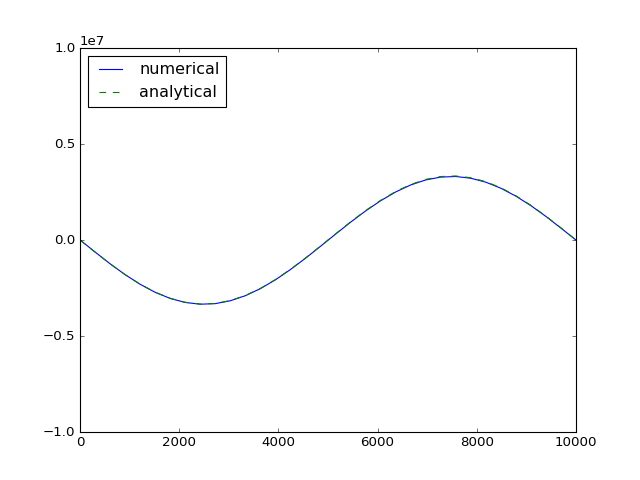

In [ ]:
p = np.zeros(nz) + p0
delta_p = 1e7

omega = 2*np.pi / T0
kz = 2 * np.pi / depth

plt.figure()
for it in np.arange(T0/dt * 5):
    t = it * dt
    
    #update kappa (depend on p) 
    coeff.update_kappa(p);
    SBP_VC.bc_mat(coeff.kappa)
    SBP_VC.D2bc_mat(coeff.kappa)
    
    #source
    g = (delta_p*(beta0*eta0*n0*omega*p1*sin(kz*z)*cos(omega*t)
        + delta_p*k0*kz**2*exp((-delta_p*sin(kz*z)*sin(omega*t) - p0)/p1)*sin(omega*t)**2*cos(kz*z)**2
        + k0*kz**2*p1*exp((-delta_p*sin(kz*z)*sin(omega*t) - p0)/p1)*sin(kz*z)*sin(omega*t))/(beta0*eta0*n0*p1))
    
    #update p
    p += 1/(coeff.n * coeff.beta) * dt *(np.dot(SBP_VC.D2bc, p) + p_R *SBP_VC.bcR + p_L *SBP_VC.bcL) + dt * g
    #analytical solution
    sol = p0 + delta_p * sin(kz * z) * sin(omega * t)
    if it % 100 == 0:
        plt.clf()
        plt.plot(z, p, label='numerical')
        plt.plot(z, sol, '--', label='analytical')
        plt.ylim([p0-delta_p,p0+delta_p])
        plt.xlim([z[0], z[-1]])
        plt.legend(loc='upper left')
        plt.gcf().canvas.draw()